<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Chapter_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Why CV fails in finance ? 

One reason k-fold CV fails in finance is because observations
cannot be assumed to be drawn from an IID process. A second reason for CV’s failure
is that the testing set is used multiple times in the process of developing a model,
leading to multiple testing and selection bias.

## Solution is 


1. Purging the trains set
2. Embargo
3. The purged k-fold class


#1.
Why is shuffling a dataset before conducting k-fold CV generally a bad idea in
finance? What is the purpose of shuffling? Why does shuffling defeat the purpose
of k-fold CV in financial datasets?

The general procedure of k-fold cv:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    1. Take the group as a hold out or test data set
    2. Take the remaining groups as a training data set
    3. Fit a model on the training set and evaluate it on the test set
    4. Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

,but in finance ...

# 2.
Take a pair of matrices (X, y), representing observed features and labels. These
could be one of the datasets derived from the exercises in Chapter 3.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
!pip install -q mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling

     |████████████████████████████████| 122kB 9.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [0]:
close = dollar_bars.close
pt_sl = [1,1]
target = util.get_daily_vol(close)
h = target.mean()
t_events = filters.cusum_filter(close,h)
vertical_barrier_times = labeling.add_vertical_barrier(t_events,close,num_days=1)

In [0]:
# side (Chapter3)

fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

side = df['side']

In [7]:
events = labeling.get_events(close, t_events, pt_sl, target, min_ret=0.005, num_threads=1, vertical_barrier_times = vertical_barrier_times ,side_prediction = side)
bin = labeling.get_bins(events,close)

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [0]:
raw_data = pd.DataFrame()

# Log Returns
raw_data['log_ret'] = np.log(close).diff()

# Momentum
raw_data['mom1'] = close.pct_change(periods=1)
raw_data['mom2'] = close.pct_change(periods=2)
raw_data['mom3'] = close.pct_change(periods=3)
raw_data['mom4'] = close.pct_change(periods=4)
raw_data['mom5'] = close.pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [9]:
raw_data2 = raw_data.shift(1)
raw_data2['side'] = side
raw_data3 = raw_data2.dropna()
y=bin.bin
X = raw_data3.loc[y.index,:]
data = X.join(y,how='right').dropna()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

## (a) Derive the performance from a 10-fold CV of an RF classifier on (X, y), without shuffling.

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_curve, confusion_matrix, auc

In [0]:
#Chapter 4
un = sampling.get_av_uniqueness_from_triple_barrier(events, close,1)
avgU = un.mean()

In [0]:
#Chapter 6
clf = RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap=False,class_weight='balanced_subsample')
clf = BaggingClassifier(base_estimator=clf,n_estimators=1000,max_samples=avgU,max_features=1)

In [0]:
#clf0=RandomForestClassifier(n_estimators=1000,class_weight='balanced_subsample', criterion='entropy')

In [0]:
skf = StratifiedKFold(n_splits=10, shuffle=False)

In [0]:
from scipy import interp
def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

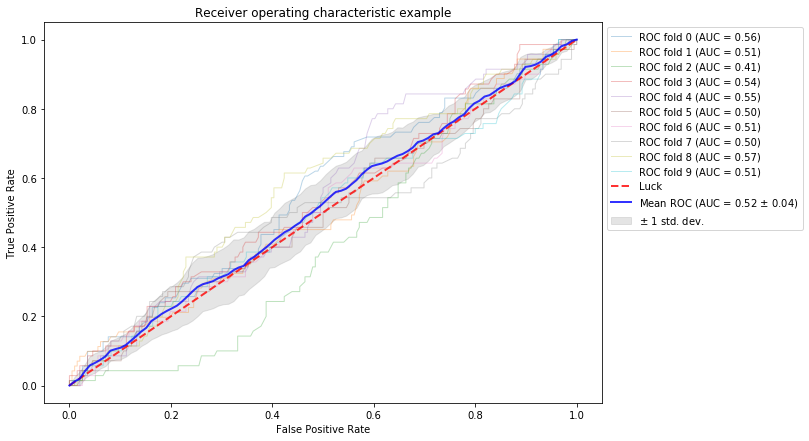

In [19]:
crossValPlot(skf,clf,X,y)

In [38]:
cross_validation.ml_cross_val_score(clf,X,y=y,cv_gen=skf).mean()

-0.585958997770845

## (b) Derive the performance from a 10-fold CV of an RF classifier on (X, y), with shuffling.

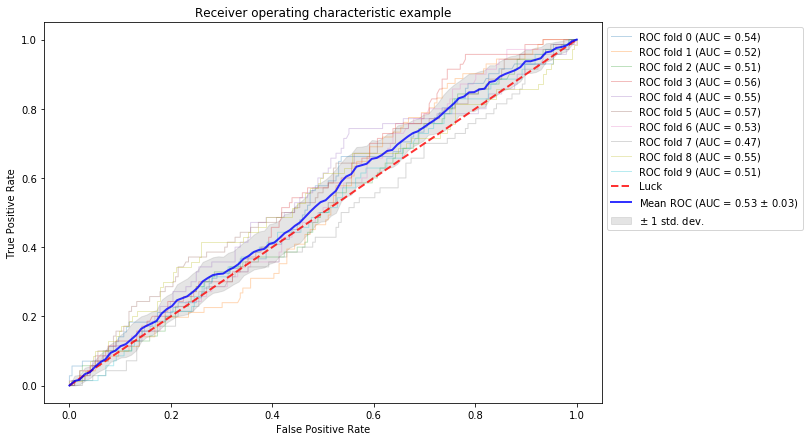

In [17]:
skfb = StratifiedKFold(n_splits=10, shuffle=True)

crossValPlot(skfb,clf,X,y)

In [40]:
cross_validation.ml_cross_val_score(clf,X,y=y,cv_gen=skfb).mean()

-0.579455479512213

둘다 전혀 좋은 결과는 아니지만 셔플한 샘플의 결과가 조금 더 괜찮다.
하지만 overfit의 문제를 생각해봐야한다.

## 3. Take the same pair of matrices (X, y) you used in exercise 2.

(a) Derive the performance from a 10-fold purged CV of an RF on (X, y), with 1% embargo.

(b) Why is the performance lower?

(c) Why is this result more realistic?

In [0]:
from mlfinlab import cross_validation

In [0]:
tmp_data = data.join(events['t1'])

In [0]:
pkf = cross_validation.PurgedKFold(n_splits=10, samples_info_sets=tmp_data['t1'], pct_embargo=0.01)

In [0]:
def crossValPlot2(skf,classifier,X,y):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

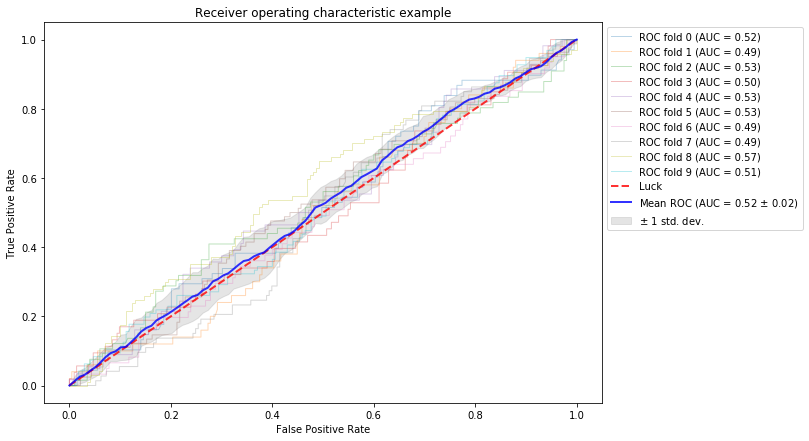

In [34]:
crossValPlot2(pkf,clf,X,y)

In [39]:
cross_validation.ml_cross_val_score(clf,X,y=y,cv_gen=pkf).mean()

-0.5848593089259808

결과는 사실 비슷함

The performance is lowered because redundant samples are minimized, shuffling is removed thereby removing leakage and an additional layer of protection is implemented between the test sets and the following train sets. This is called an embargo which serves to further eliminate leakage between train and test sets.

Preventing information leakage results in performance that is closer to out of sample performance where the future is unknowable.

참고 : github/BlackArbsCEO